In [1]:
import os
import yaml

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

import zarr
import dask.array as da

from utils.utility_functions import transposeZarr, compare_clusters, u_stats, plot

In [2]:
# specify VAE20 clustering and associated window size and latent dimension
vae_output_dir, clustering, window_size, latent_dim = ('VAE20', 'VAE20', 30, 850)

# specify cluster pairs
pairs = [(12, 15)]

In [3]:
# I/O
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

# image contrast settings
contrast_limits = yaml.safe_load(open(os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')))

antibody_abbrs = {
    'anti_CD3': 'CD3', 'anti_CD45RO': 'CD45RO', 'Keratin_570': 'Keratin', 'aSMA_660': 'aSMA',
    'CD4_488': 'CD4', 'CD45_PE': 'CD45', 'PD1_647': 'PD1', 'CD20_488': 'CD20', 'CD68_555': 'CD68',
    'CD8a_660': 'CD8a', 'CD163_488': 'CD163', 'FOXP3_570': 'FOXP3', 'PDL1_647': 'PDL1',
    'Ecad_488': 'ECAD', 'Vimentin_555': 'Vimentin', 'CDX2_647': 'CDX2', 'LaminABC_488': 'LaminABC',
    'Desmin_555': 'Desmin', 'CD31_647': 'CD31', 'PCNA_488': 'PCNA', 'CollagenIV_647': 'CollagenIV'
}

root = os.path.join(os.getcwd(), f'input/{vae_output_dir}')

# read combined training, validation, and test thumbnails
X_combo = zarr.open(os.path.join(root, f'6_latent_space_LD{latent_dim}/combined_zarr'))

# rearrange Zarr dimensions to conform to expected VAE input (i.e. cells, x, y, channels)
X_combo = transposeZarr(z=X_combo)

# output directory
out = os.path.join(os.getcwd(), f'output/img_similarity')
if not os.path.exists(out):
    os.makedirs(out)


(12, 15)


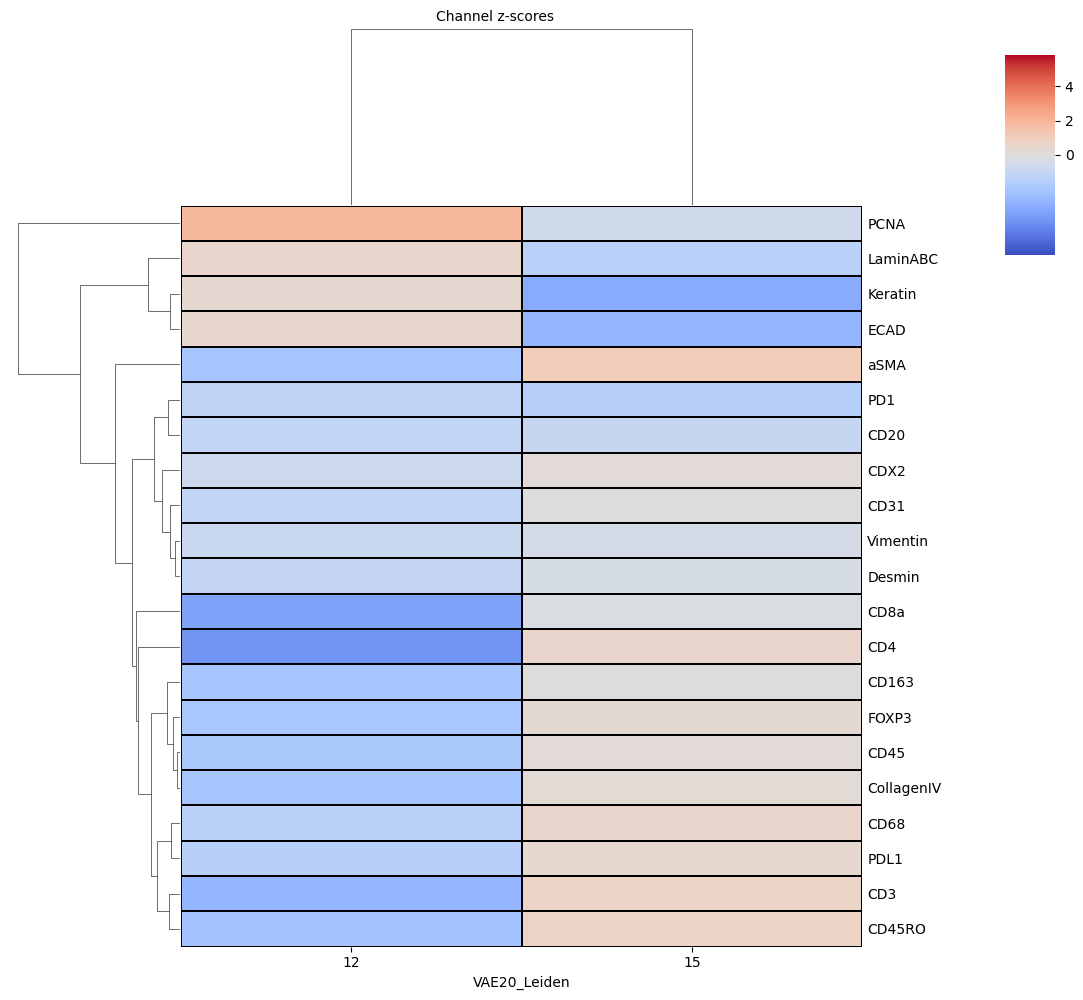


Computing MSE for Cluster: 12, Channel: CD3e


100%|████████████████████████████████████████████████████████| 124750/124750 [6:30:33<00:00,  5.32it/s]
/Users/greg/projects/vae-paper/src/utils/utility_functions.py:342: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  marker_df = pd.concat([marker_df, cluster_df], axis=0)


Computing MSE for Cluster: 15, Channel: CD3e


100%|████████████████████████████████████████████████████████| 124750/124750 [5:03:40<00:00,  6.85it/s]
/Users/greg/projects/vae-paper/src/utils/utility_functions.py:384: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, marker_df], axis=0)



Computing MSE for Cluster: 12, Channel: CD45


100%|████████████████████████████████████████████████████████| 124750/124750 [6:46:34<00:00,  5.11it/s]
/Users/greg/projects/vae-paper/src/utils/utility_functions.py:342: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  marker_df = pd.concat([marker_df, cluster_df], axis=0)


Computing MSE for Cluster: 15, Channel: CD45


100%|████████████████████████████████████████████████████████| 124750/124750 [7:08:47<00:00,  4.85it/s]



Computing MSE for Cluster: 12, Channel: CD8a


100%|████████████████████████████████████████████████████████| 124750/124750 [5:23:35<00:00,  6.43it/s]
/Users/greg/projects/vae-paper/src/utils/utility_functions.py:342: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  marker_df = pd.concat([marker_df, cluster_df], axis=0)


Computing MSE for Cluster: 15, Channel: CD8a


100%|████████████████████████████████████████████████████████| 124750/124750 [5:33:45<00:00,  6.23it/s]



Computing MSE for Cluster: 12, Channel: PCNA


100%|████████████████████████████████████████████████████████| 124750/124750 [5:31:34<00:00,  6.27it/s]
/Users/greg/projects/vae-paper/src/utils/utility_functions.py:342: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  marker_df = pd.concat([marker_df, cluster_df], axis=0)


Computing MSE for Cluster: 15, Channel: PCNA


100%|████████████████████████████████████████████████████████| 124750/124750 [5:48:45<00:00,  5.96it/s]



Computing MSE across clusters 12v15 for channel: CD3e


100%|██████████████████████████████████████████████████████████████| 500/500 [9:53:21<00:00, 71.20s/it]


Computing MSE across clusters 12v15 for channel: CD45


100%|█████████████████████████████████████████████████████████████| 500/500 [10:36:12<00:00, 76.35s/it]


Computing MSE across clusters 12v15 for channel: CD8a


100%|█████████████████████████████████████████████████████████████| 500/500 [10:56:18<00:00, 78.76s/it]


Computing MSE across clusters 12v15 for channel: PCNA


100%|█████████████████████████████████████████████████████████████| 500/500 [13:13:59<00:00, 95.28s/it]



MSE U-stats:
          u-stat           pval  plot_ch
0   1.392465e+10   0.000000e+00        0
5   1.448295e+10  1.801973e-277        1
9   1.291331e+10   0.000000e+00        2
19  1.299593e+10   0.000000e+00        3



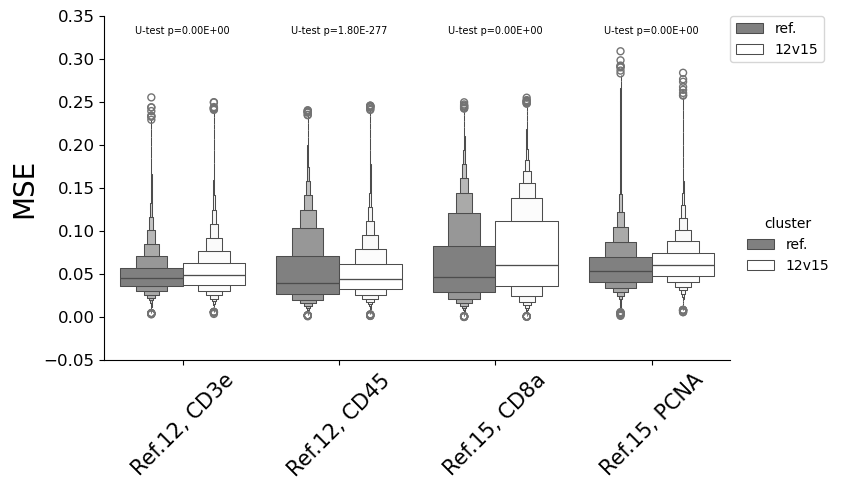

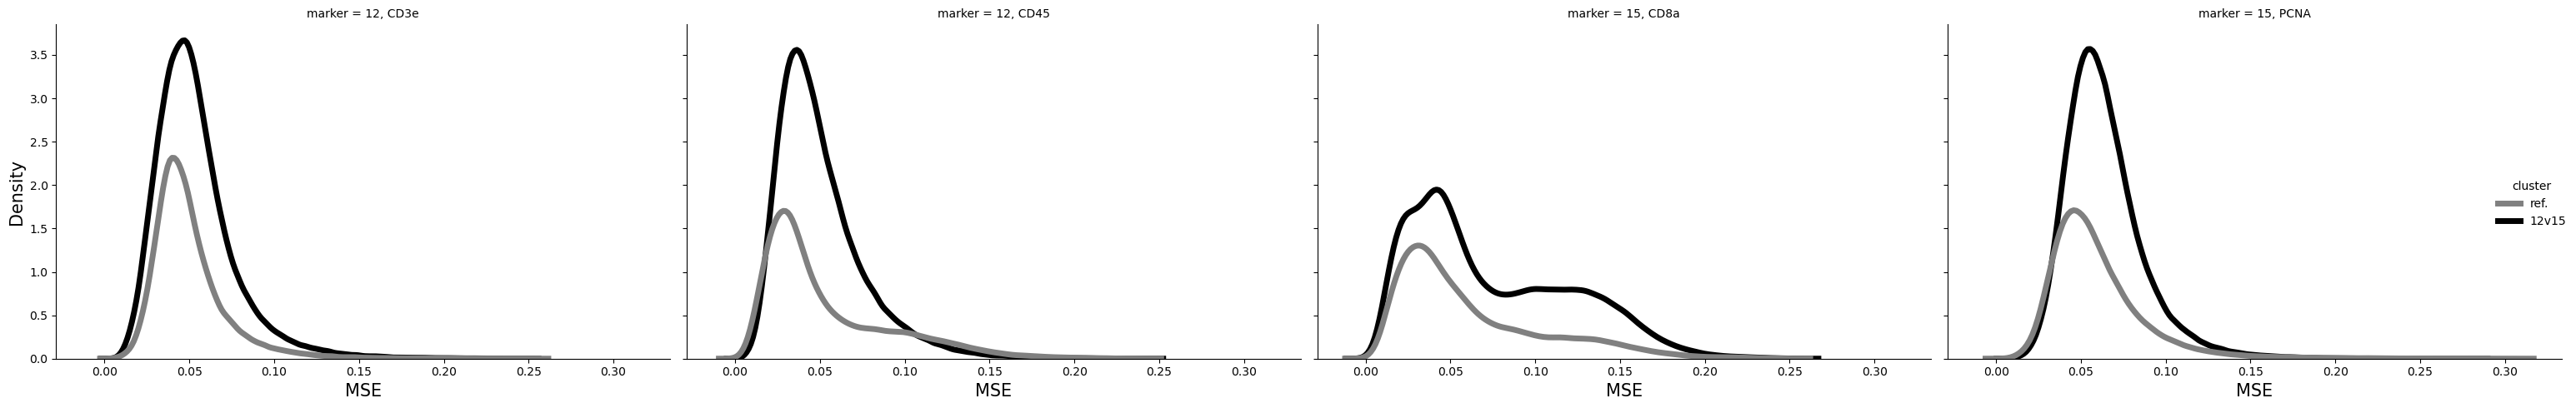

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


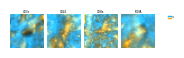

In [4]:
# compute median values of per patch, per channel pixel intensity medians
medians = da.median(X_combo, axis=(1, 2)).compute()
clustermap_input = pd.DataFrame(columns=[i for i in antibody_abbrs.keys()], data=medians)
clustermap_input[clustering] = main[clustering]
clustermap_input = clustermap_input.groupby(clustering).median()

# compute per channel z-scores across clusters
clustermap_input = (clustermap_input-clustermap_input.mean())/clustermap_input.std()

# zero-center colorbar
norm = TwoSlopeNorm(vcenter=0, vmin=clustermap_input.min().min(), vmax=clustermap_input.max().max())

print()
channels = {'CD3e': 0, 'CD45': 5, 'CD8a' : 9, 'PCNA': 19}
for clus_pair in pairs:

    print(clus_pair)

    combo_label = f'{clus_pair[0]}v{clus_pair[1]}'

    save_dir = os.path.join(out, combo_label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    clustermap_subset = clustermap_input[clustermap_input.index.isin(clus_pair)]

    g = sns.clustermap(
        clustermap_subset.T, cmap='coolwarm', standard_scale=None, yticklabels=1, xticklabels=1,
        linewidths=0.1, linecolor='k', cbar=True, norm=norm 
    )
    g.ax_heatmap.set_xticklabels(
        [i.get_text() for i in g.ax_heatmap.get_xticklabels()], rotation=0
    )
    g.ax_heatmap.set_yticklabels(
        [antibody_abbrs[i.get_text()] for i in g.ax_heatmap.get_yticklabels()], rotation=0
    )
    g.ax_cbar.set_position([1.01, 0.75, 0.05, 0.2])
    g.fig.suptitle('Channel z-scores', y=0.995, fontsize=10)
    g.ax_heatmap.yaxis.set_tick_params(length=0.05, width=0.01)
    plt.savefig(os.path.join(out, 'channel_z-scores.pdf'), bbox_inches='tight')
    plt.show()

    # get positional indices of clustering cells (aligned with X_combo)
    clus1_idxs = main.index[main[clustering] == clus_pair[0]]
    clus2_idxs = main.index[main[clustering] == clus_pair[1]]

    # take subsets
    clus1_idxs = clus1_idxs[0:500]  # 500
    clus2_idxs = clus2_idxs[0:500]

    for metric in ['MSE']:
  
        df, cluster_select, sq_err = compare_clusters(
            clus1_name=clus_pair[0], clus1_idxs=clus1_idxs,
            clus2_name=clus_pair[1], clus2_idxs=clus2_idxs,
            metric=metric, channels=channels,
            X_combo=X_combo, combo_label=combo_label,
            save_dir=save_dir, window_size=window_size
        )
    
        # save dataframe with metric values
        df.reset_index(drop=True, inplace=True)
        df.to_csv(os.path.join(save_dir, f'{metric}.csv'), index=False)

        # create dataframe of stored t-test stats
        stats = u_stats(
            df=df, metric=metric, cluster_select=cluster_select,
            channels=channels, combo_label=combo_label
        )

        # plot metric data
        plot(
            df=df, metric=metric, stats=stats, sq_err=sq_err,
            combo_label=combo_label, clus_pair=clus_pair, save_dir=save_dir
        )